In [162]:
%load_ext autoreload
%autoreload 2

In [1]:
from fastai2.vision.all import *
from fastai2.text.all import *
path =  Path('/notebooks/storage/data/hate/data')

In [2]:
df = pd.read_json(path/'data.json')

In [3]:
txt_block = TextBlock.from_df('text')
txt_block

In [4]:
class MyDL(TfmdDL):
    def do_batch(self, b):
        #breakpoint()
        r = self.before_batch(b)
        r = self.create_batch(r)
        r = self.retain(r,b)
        return r
    
    def do_item(self, s):
        try:
            #breakpoint()
            item = self.create_item(s)
            item = self.after_item(item)
            return item
        except SkipItemException: return None

In [5]:
dblock = DataBlock(blocks=(txt_block, ImageBlock, CategoryBlock),
                           get_x=[ColReader('text'), ColReader('img', pref=f'{path}/')],
                           get_y=ColReader('label'),
                           splitter=ColSplitter('is_valid'),
                           item_tfms=RandomResizedCrop(128),
                           batch_tfms=aug_transforms(),
                           dl_type = MyDL)

In [6]:

dls = DataLoaders.from_dblock(dblock,df, path, verbose=True)

Setting up after_item: Pipeline: RandomResizedCrop -> ToTensor
Setting up before_batch: Pipeline: partial
Setting up after_batch: Pipeline: IntToFloatTensor -> AffineCoordTfm -> LightingTfm


In [7]:
te, im, y = dls.train.one_batch()
te.shape, im.shape

(torch.Size([64, 34]), torch.Size([64, 3, 128, 128]))

xxbos xxunk xxunk xxunk xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad
xxbos karen get your shit together xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad
xxbos black people anything that does n't belong to them xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad
xxbos all she wants to do is play all day xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xx

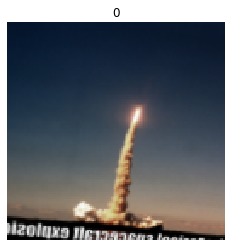

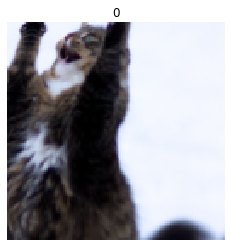

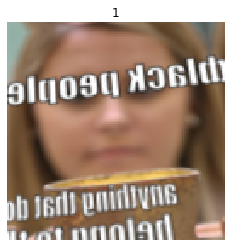

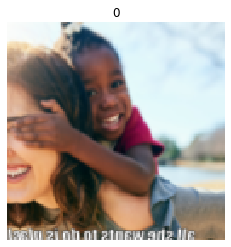

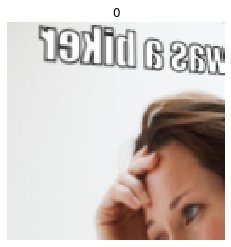

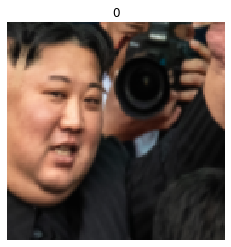

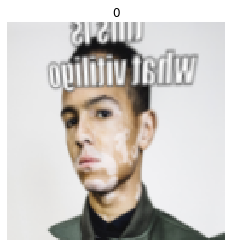

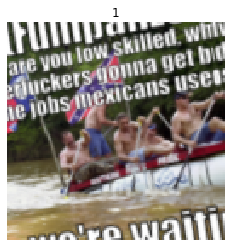

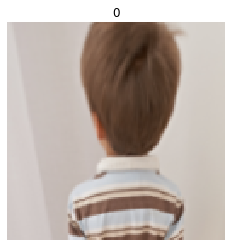

In [8]:
dls.show_batch()

In [9]:
class Image2embs(Module):
    def __init__(self, emb_sz=400):
        self.emb_sz = emb_sz
        enc = resnet34(pretrained=True)
        self.stem  = nn.Sequential(*list(enc.children())[:-3])
        self.emb_conv = nn.Conv2d(256, emb_sz, kernel_size=3, padding=1)
    def forward(self, x):
        x = self.stem(x)
        x = self.emb_conv(x)
        x = x.view(x.shape[0], self.emb_sz, -1).permute((0,2,1))
        return x
md = Image2embs().cuda()
md(im).shape

torch.Size([64, 64, 400])

In [130]:
class TextImageModel(torch.nn.Module):
    def __init__(self, text_encoder, classifier):
        super().__init__()
        self.pad_idx = 1
        self.text_enc = text_encoder
        self.classifier = classifier
        self.img_enc = Image2embs()
    def forward(self, text, img):
        img_embs = self.img_enc(img)
        text_embs = self.text_enc.encoder(text)
        all_embs = torch.cat((img_embs, text_embs), dim=1)
        txt_mask = text == self.pad_idx
        img_mask = torch.zeros_like(img_embs[:,:,0]).bool()
        mask = torch.cat((img_mask, txt_mask), dim=1)
        #print(mask.shape, all_embs.shape)
        r = self.text_enc(all_embs, True)
        r = self.classifier((r , mask))
        return r
    def reset(self):
        self.text_enc.reset()

In [116]:
def my_split(model):
    #groups= L([nn.Sequential(model.img_enc.stem, model.text_enc), nn.Sequential(model.img_enc.emb_conv, model.classifier)])
    groups = L([model])
    return groups.map(params)
    

In [117]:
from fastai2.text.models.core import _model_meta
def text_classifier_learner(dls, arch, seq_len=72, config=None, pretrained=True, drop_mult=0.5, n_out=None,
                            lin_ftrs=None, ps=None, max_len=72*20, y_range=None, **kwargs):
    "Create a `Learner` with a text classifier from `dls` and `arch`."
    vocab = dls.vocab[0]
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be infered from data, set `dls.c` or pass `n_out`"
    model = get_text_classifier(arch, len(vocab), n_out, seq_len=seq_len, config=config, y_range=y_range,
                                drop_mult=drop_mult, lin_ftrs=lin_ftrs, ps=ps, max_len=max_len)
    meta = _model_meta[arch]
    learn = TextLearner(dls, model, splitter=my_split, **kwargs)
    print('created learner')
    if pretrained:
        if 'url' not in meta:
            warn("There are no pretrained weights for that architecture yet!")
            return learn
        model_path = untar_data(meta['url'], c_key='model')
        fnames = [list(model_path.glob(f'*.{ext}'))[0] for ext in ['pth', 'pkl']]
        learn = learn.load_pretrained(*fnames, model=learn.model.text_enc)
        learn.freeze()
    return learn

def get_text_classifier(arch, vocab_sz, n_class, seq_len=80, config=None, drop_mult=1., lin_ftrs=None,
                        ps=None, pad_idx=1, max_len=72*20, y_range=None):
    "Create a text classifier from `arch` and its `config`, maybe `pretrained`"
    meta = _model_meta[arch]
    config = ifnone(config, meta['config_clas']).copy()
    for k in config.keys():
        if k.endswith('_p'): config[k] *= drop_mult
    if lin_ftrs is None: lin_ftrs = [50]
    if ps is None:  ps = [0.1]*len(lin_ftrs)
    layers = [config[meta['hid_name']] * 3] + lin_ftrs + [n_class]
    ps = [config.pop('output_p')] + ps
    init = config.pop('init') if 'init' in config else None
    #encoder = SentenceEncoder(seq_len, arch(vocab_sz, **config), pad_idx=pad_idx, max_len=max_len)
    encoder = arch(vocab_sz, **config).cuda()
    print('encoder', encoder.hidden[0][0])
    classifier = PoolingLinearClassifier(layers, ps, bptt=seq_len, y_range=y_range).cuda()
    model = TextImageModel(encoder, classifier).cuda()
    #model = SequentialRNN(encoder, PoolingLinearClassifier(layers, ps, bptt=seq_len, y_range=y_range))
    print(init)
    return model if init is None else model.apply(init)

In [145]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.6, metrics=[accuracy, RocAucBinary()], cbs=SaveModelCallback(monitor='roc_auc_score'))

encoder tensor([[[0., 0., 0.,  ..., 0., 0., 0.]]])
None
created learner


In [146]:
md = learn.model
to_freeze = [md.text_enc, md.img_enc.stem]
for m in to_freeze:
    for p in m.parameters():
        p.requires_grad_(False)

In [147]:
learn.fit_one_cycle(10, lr=1e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.866888,0.737732,0.546000,0.547824,00:33
1,0.845902,0.708712,0.544000,0.532656,00:32
2,0.780033,0.744642,0.508000,0.507072,00:33
3,0.738686,0.760196,0.510000,0.524928,00:32
4,0.726614,0.760700,0.510000,0.606272,00:33
5,0.719352,0.730603,0.526000,0.617728,00:32
6,0.715007,0.758999,0.520000,0.555728,00:32
7,0.703659,0.767192,0.522000,0.577216,00:31
8,0.698896,0.757890,0.526000,0.569776,00:32
9,0.690462,0.749156,0.526000,0.567968,00:32


In [148]:
md = learn.model
to_freeze = [md.text_enc, md.img_enc.stem]
for m in to_freeze:
    for p in m.parameters():
        p.requires_grad_(True)

In [149]:
learn.fit_one_cycle(6, lr=1e-4 )

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.649611,0.773702,0.536000,0.553184,00:41
1,0.589543,0.766827,0.568000,0.627568,00:41
2,0.550431,0.792119,0.572000,0.631504,00:41
3,0.510495,0.785782,0.564000,0.637088,00:41
4,0.458350,0.883221,0.544000,0.624864,00:41
5,0.426377,0.857004,0.550000,0.622272,00:41


In [150]:
preds = learn.get_preds(dl=dls.valid)

In [154]:
accuracy(*preds)

tensor(0.5640)

In [165]:
from util import *

In [167]:
gen_submit(learn, path, 'attempt4.csv')